In [1]:
import OpenCity

# Build geometry for state

In [2]:
fips=25
year=2017
geom_type='block'
centre= {'lat': 42.352927, 'lon': -71.059435}
centre_x_y=[centre['lon'], centre['lat']]

model_area_radius=5000
sim_area_radius=1000

state=OpenCity.US_State(state_fips=fips, year=year, 
#                         geom_type=geom_type
                       )
state.get_geometry()

Getting geometry (block_group) for state: Massachusetts


/Volumes/GoogleDrive/My Drive/OpenCity/OpenCity.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids=self.geom['geometry'].centroid


In [3]:
state.subset_geom_by_distance(centre_x_y, model_area_radius, 'model_area')
state.subset_geom_by_distance(centre_x_y, sim_area_radius, 'vis_area')

	 Subsetting zones by distance
	 Subsetting zones by distance


In [4]:
all_zones=state.return_geometry()
print(len(all_zones))

4985


In [5]:
sim_zones=state.return_geometry('vis_area')
print(len(sim_zones))

22


In [6]:
model_zones=state.return_geometry('model_area')
print(len(model_zones))

347


<AxesSubplot:>

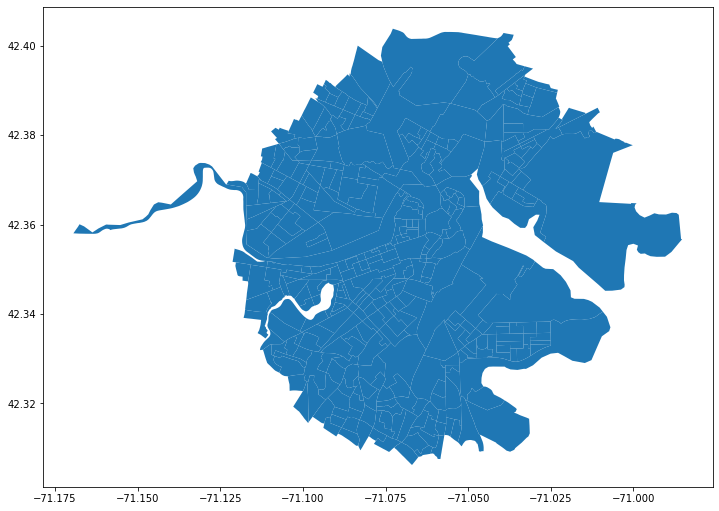

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(12,12))
model_zones.plot(ax=ax)

# Get commuting data for state from LEHD

In [8]:
state.get_lodes_data()

Getting WAC data from https://lehd.ces.census.gov/data/lodes/LODES7/
	 Formatting WAC data
Getting RAC data from https://lehd.ces.census.gov/data/lodes/LODES7/
	 Formatting RAC data
Getting OD data from https://lehd.ces.census.gov/data/lodes/LODES7/
	 Formatting OD data


The commuting data can be used to simulate a population

In [9]:
simpop_df=state.lodes_to_pop_table(subset_name='model_area')

Using 27680 of 1498059 rows in OD data
0 of 27680
10000 of 27680
20000 of 27680


# Build mobility system for same area

The MobilitySystem class requries the networks to be specified as pandana networks. The network data to create the pandana network objects can be obtained using the osmnet library or using any other method.

In [10]:
import pandana
import osmnet

networks={}

bbox=state.get_bounds(subset_name='model_area')
drive_nodes_df,drive_edges_df=osmnet.load.network_from_bbox(lat_min=bbox[1], lng_min=bbox[0], lat_max=bbox[3], 
                          lng_max=bbox[2], bbox=None, network_type='drive', 
                          two_way=True, timeout=180, 
                          custom_osm_filter=None)
drive_edges_df['travel_time']=drive_edges_df['distance']*50000/3600

drive_net=pandana.Network(drive_nodes_df["x"], drive_nodes_df["y"], drive_edges_df["from"], drive_edges_df["to"],
                 drive_edges_df[["distance", "travel_time"]])

networks['drive']=OpenCity.PdnaNetwork(drive_net)

/Users/doorleyr/anaconda/envs/pandana/lib/python3.9/site-packages/osmnet/load.py:445: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/Users/doorleyr/anaconda/envs/pandana/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"cycleway|footway|path|pedestrian|steps|track|proposed|construction|bridleway|abandoned|platform|raceway|service"]["motor_vehicle"!~"no"]["motorcar"!~"no"]["service"!~"parking|parking_aisle|driveway|emergency_access"](42.30624500,-71.16947400,42.40381000,-70.98527300);>;);out;'}"
Downloaded 18,474.3KB from www.overpass-api.de in 5.22 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 5.69 seconds
Returning OSM data with 81,022 nodes and 12,547 ways...
Edge node pairs completed. Took 15.39 seconds
Returning processed graph with 13,346 nodes and 19,447 edges...
Completed OSM data download and Pandana node and edge table creation in 22.82 seconds
building link attribute lookup


Define modes of transportation

In [11]:
drive_dict={
    'target_network_id': 'drive',
    'travel_time_metric': 'travel_time'}
modes={'drive': OpenCity.Mode(drive_dict)}

Create mobility system using the pandana network(s) and mode definition(s)

In [12]:
mob_sys=OpenCity.MobilitySystem(modes=modes,
                      networks=networks)

# Create the Simulation Model

In [13]:
sim=OpenCity.Simulation(simpop_df, mob_sys, model_zones)
simpop_df=sim.get_simpop_subset(simpop_df, sample_N=1000, sim_geoids=list(sim_zones.index))

Finding closest nodes to every zone centroid


In [14]:
simpop_df=sim.create_activity_schedules(simpop_df)

Scheduling activities
Chhosing locations for each activity


In [15]:
all_trips_df=sim.create_trip_table(simpop_df)

Choosing modes


In [16]:
route_table=sim.get_routes_table(all_trips_df)

In [17]:
route_gdf=sim.route_table_to_geo(route_table)

In [18]:
route_gdf.head()

,from_activity,to_activity,from_zone,to_zone,person_id,start_time,age,earnings,industry,mode,from_node_drive,to_node_drive,node_path,attributes,line_string
0,H,W,250250107023,250250303003,37944,26940.302092,30to54,3333plus,other,drive,61341776,6162811202,"[61341776, 61341774, 61501392, 61341785, 10389...","{'distance': [205.407796, 40.909196, 95.529583...","LINESTRING (-71.07384 42.35287, -71.07150 42.3..."
1,W,O,250250303003,250173515001,37944,39770.728986,30to54,3333plus,other,drive,6162811202,71948254,"[6162811202, 1522224143, 1522224154, 61430123,...","{'distance': [140.161535, 55.407077, 35.729105...","LINESTRING (-71.05979 42.35964, -71.06068 42.3..."
2,O,W,250173515001,250250303003,37944,44323.301284,30to54,3333plus,other,drive,71948254,6162811202,"[71948254, 71925505, 958887680, 958886909, 958...","{'distance': [20.404323, 83.302613, 26.320976,...","LINESTRING (-71.08087 42.37740, -71.08088 42.3..."
3,W,H,250250303003,250250107023,37944,60417.425450,30to54,3333plus,other,drive,6162811202,61341776,"[6162811202, 6990594259, 731633442, 61463265, ...","{'distance': [14.43331, 35.39799, 39.772767, 6...","LINESTRING (-71.05979 42.35964, -71.05975 42.3..."
4,H,W,250250108022,250250701011,39738,31066.306783,u30,u1250,other,drive,61340721,2934870538,"[61340721, 61341278, 61342409, 61342331, 61342...","{'distance': [92.682621, 95.756635, 40.484562,...","LINESTRING (-71.08700 42.35151, -71.08662 42.3..."


# Visualising Outputs

Get resulting trips as a GeoDataFrame of 'LineString's

<AxesSubplot:>

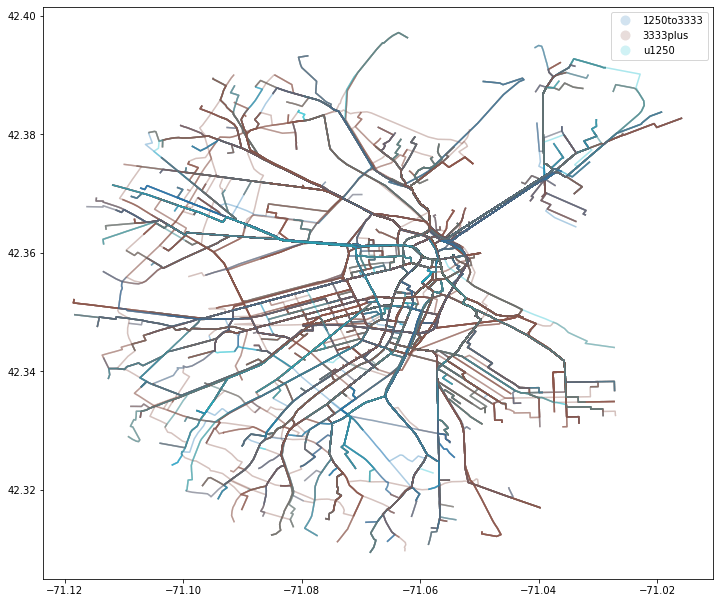

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(12,12))
route_gdf.plot(column='earnings', legend=True, alpha=0.2, ax=ax)

Get resulting trips as a geojson compatible with the [kepler.gl](https://kepler.gl/) [Trips Layer](https://deck.gl/docs/api-reference/geo-layers/trips-layer). 'start_day_time_stamp' should be the timestamp in epoch seconds format at midnight at the beginning of the day being simulated.

In [20]:
start_day_time_stamp=1578268800
geo_dict=sim.route_gdf_to_trips_geojson(route_gdf, start_day_time_stamp)

In [21]:
geo_dict.keys()

dict_keys(['type', 'features', 'bbox'])

In [22]:
geo_dict['features'][0]

{'id': '0',
 'type': 'Feature',
 'properties': {'age': '30to54',
  'earnings': '3333plus',
  'from_activity': 'H',
  'from_node_drive': 61341776,
  'from_zone': '250250107023',
  'industry': 'other',
  'mode': 'drive',
  'person_id': 37944,
  'start_time': 26940.302091866815,
  'to_activity': 'W',
  'to_node_drive': 6162811202,
  'to_zone': '250250303003'},
 'geometry': {'type': 'LineString',
  'coordinates': [[-71.073844, 42.3528677, 0, 1578295740],
   [-71.0714973, 42.3535025, 0, 1578298593],
   [-71.0716676, 42.3538481, 0, 1578299161],
   [-71.0720654, 42.3546551, 0, 1578300488],
   [-71.0723266, 42.3552136, 0, 1578301401],
   [-71.0720408, 42.3555649, 0, 1578302034],
   [-71.0713917, 42.355737, 0, 1578302821],
   [-71.0698455, 42.3560814, 0, 1578304665],
   [-71.0695023, 42.3561971, 0, 1578305095],
   [-71.0693775, 42.356225, 0, 1578305244],
   [-71.0691333, 42.3562554, 0, 1578305527],
   [-71.0676147, 42.3565931, 0, 1578307337],
   [-71.065788, 42.3570099, 0, 1578309520],
   [-71.